# Stimmungsanalyse auf IMDb-Datensatz mit NLP (Teil I)

## Step 1: Problem definition

### 1.1 Projektziel

Das Hauptziel dieses Projekts ist die Entwicklung eines Stimmungsanalyse-Modells zur Klassifizierung von Filmbewertungen aus dem IMDB-Datensatz als entweder positiv (1) oder negativ (0). Die Aufgabe wird als binäres Klassifizierungsproblem formuliert, bei dem wir die Stimmung jeder Rezension vorhersagen. In diesem Notizbuch werden wir uns auf die Datenerfassung, -verarbeitung und -extraktion konzentrieren, um ein NLP-Modell zu erstellen.



### 1.2 Datenübersicht

Der Datensatz besteht aus Folgendem:

- Rezensionen: Textdaten mit Nutzermeinungen zu Filmen.
- Stimmungen: Kennzeichnungen für jede Bewertung, wobei 1 eine positive und 0 eine negative Bewertung angibt.

## Schritt 2: Explorative Datenanalyse (EDA)


### 2.1 Laden und Vorschau der Daten


Zunächst laden wir den Datensatz und zeigen ihn in der Vorschau an. Es geht darum, die ersten Zeilen zu prüfen, um die Struktur des Datensatzes zu untersuchen und sicherzustellen, dass er die erwarteten Spalten enthält: "Bewertung" (Text) und "Stimmung" (binäres Label).

In [ ]:
!pip install datasets
!pip install nltk

In [ ]:
from datasets import load_dataset
import pandas as pd

In [ ]:
# Load the IMDb dataset
dataset = load_dataset('imdb')

# Sample data (in order to avoid RAM issues)
sample_size = 500
train_sample = dataset['train'].shuffle(seed=42).select(range(sample_size))
test_sample = dataset['test'].shuffle(seed=42).select(range(sample_size))

# Convert samples to pandas DataFrames
df = pd.DataFrame(train_sample)
df_s = pd.DataFrame(test_sample)
df.rename(columns={'text': 'review', 'label': 'sentiment'}, inplace=True)
df.head()

,review,sentiment
0,<br /><br />When I unsuspectedly rented A Thou...,1
1,This is the latest entry in the long series of...,1
2,This movie was so frustrating. Everything seem...,0
3,"I was truly and wonderfully surprised at ""O' B...",1
4,This movie spends most of its time preaching t...,0


### 2.2 Prüfung auf fehlende Werte

Es ist wichtig, festzustellen, ob im Datensatz fehlende Werte vorhanden sind. Fehlende Daten können beim Modelltraining Probleme verursachen. Wenn fehlende Werte gefunden werden, können wir sie durch Imputation oder Entfernung behandeln.

In [ ]:
# Check for missing values
missing_data = df.isnull().sum()

# Display missing values for each column
print("Missing Data:\n", missing_data)

Missing Data:
 review       0
sentiment    0
dtype: int64


### 2.3 Verteilung der Sentiments

Als Nächstes visualisieren wir die Verteilung der Sentiment-Labels.

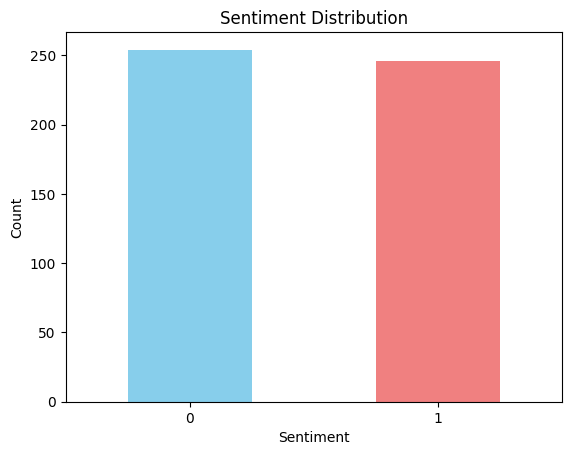

In [ ]:
import matplotlib.pyplot as plt

# Plot the distribution of sentiments (positive/negative reviews)
df['sentiment'].value_counts().plot(kind='bar', color=['skyblue', 'lightcoral'])
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

Für das Training wird ein ausgewogener Datensatz bevorzugt. Wenn der Datensatz unausgewogen ist (mehr positive oder negative Bewertungen), müssen wir möglicherweise Techniken wie Resampling oder die Verwendung gewichteter Verlustfunktionen in Betracht ziehen.

### 2.4 Analyse der Überprüfungsdauer


Wir analysieren die Länge der Rezensionen, um ihre Variabilität zu verstehen. Längere Bewertungen können mehr Kontext enthalten, aber sie führen auch zu Rauschen. Wir können entscheiden, ob wir die Bewertungen auf der Grundlage ihrer Länge abschneiden oder auffüllen.

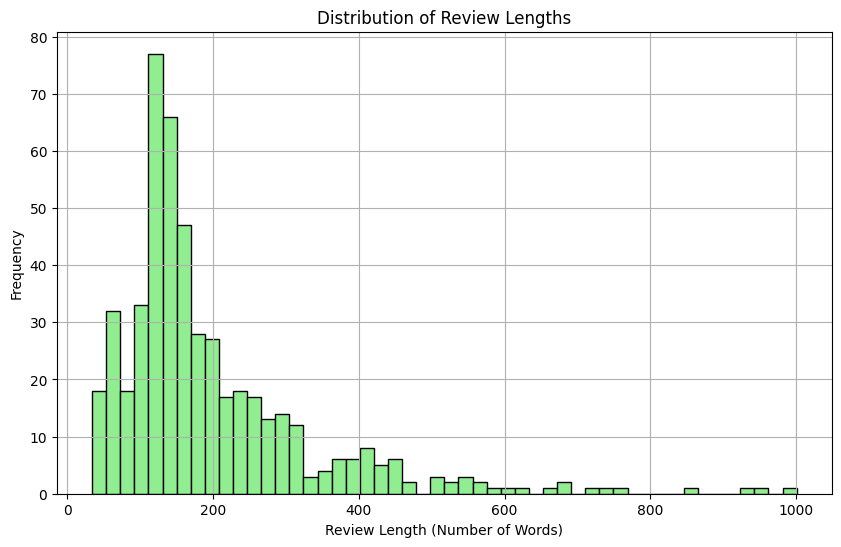

In [ ]:
# Add a column for the length of each review
df['review_length'] = df['review'].apply(lambda x: len(x.split()))

# Plot distribution of review lengths
plt.figure(figsize=(10,6))
df['review_length'].hist(bins=50, color='lightgreen', edgecolor='black')
plt.title('Distribution of Review Lengths')
plt.xlabel('Review Length (Number of Words)')
plt.ylabel('Frequency')
plt.show()


### 2.5 Worthäufigkeit nach Stimmungen

Wir erstellen ein Histogramm, um die am häufigsten verwendeten Wörter in positiven und negativen Bewertungen zu visualisieren. Die Wortwolken helfen uns dabei, häufige Begriffe sowohl in positiven als auch in negativen Bewertungen zu identifizieren. Diese Erkenntnisse können in den Prozess der Merkmalsentwicklung einfließen.

In [ ]:
# NLTK (Natural Language Toolkit) is a powerful Python library for working with human language data,
#   offering tools for tasks like tokenization, stemming, parsing, and more in natural language processing.
pip install nltk

In [ ]:
# Importing the NLTK library to use its natural language processing tools
import nltk

# Downloading 'punkt' for tokenization purposes
# 'punkt' allows us to split a sentence into individual words or tokens
nltk.download('punkt')

# Downloading 'stopwords' to filter out common English words like 'the,' 'is,' 'and,' etc.
# These words do not add meaningful insights in text analysis and are removed during preprocessing
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
import re  # Provides regular expression support to clean and preprocess text, such as removing numbers or special characters.
import matplotlib.pyplot as plt  # Used for creating visualizations, such as bar plots, to display word frequency data.
from collections import Counter  # Offers a convenient way to count occurrences of elements in an iterable, e.g., word frequency.
from nltk.corpus import stopwords  # Contains pre-defined lists of common words (like "the", "is") that can be filtered out during text preprocessing.
from nltk.tokenize import word_tokenize  # Used to split text into individual words (tokens) for further processing, such as frequency counting.
nltk.download('punkt_tab') # punkt tokenizer model that contains pre-trained data for sentence splitting and tokenization, enabling it to handle abbreviations, punctuation, and complex sentence structures.


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

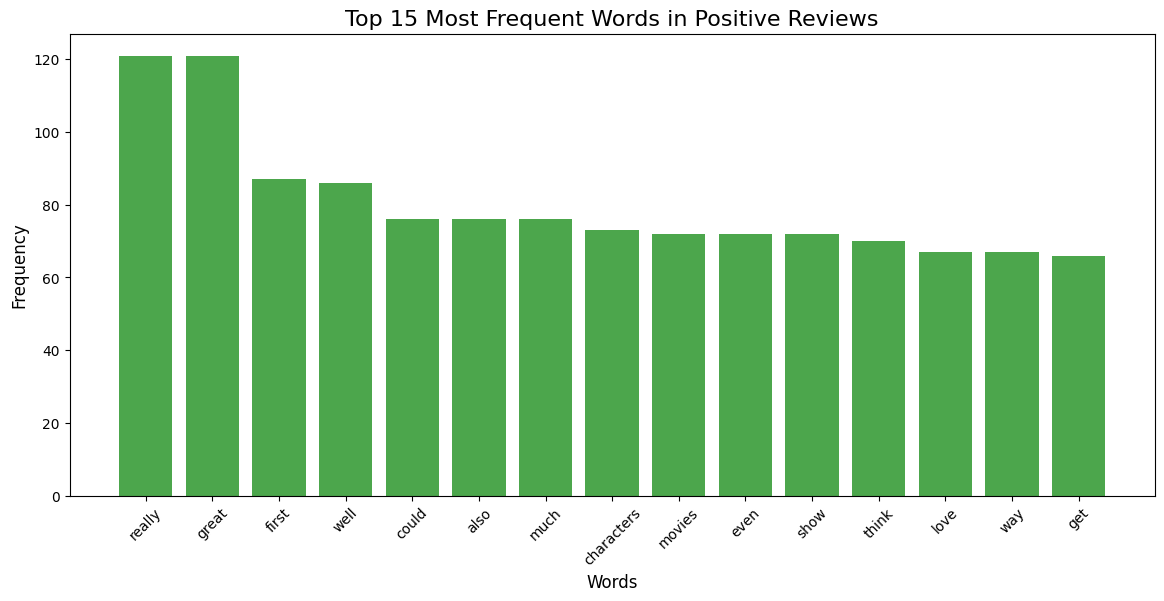

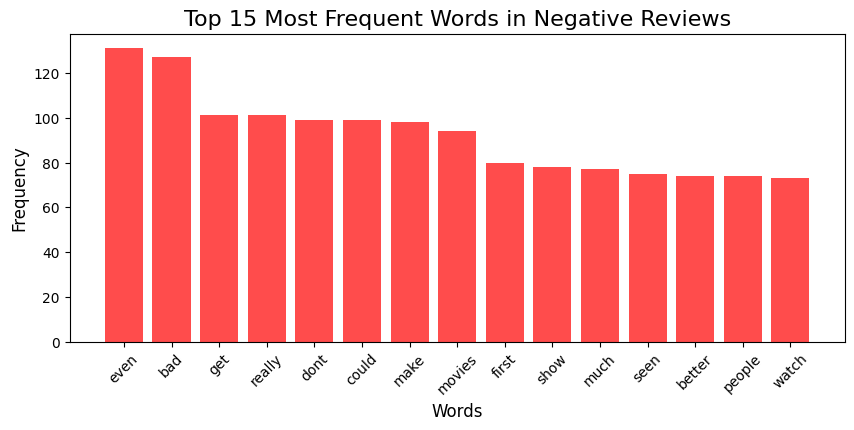

In [ ]:
# Load English stopwords
stop_words = set(stopwords.words('english'))

# Additional words to remove
custom_stop_words = {'br', 'like', 'movie', 'movies', 'film', 'one','story','time','see','would','films','good','time'}

# Function to clean the text
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    return text

# Clean the reviews
df['clean_review'] = df['review'].apply(clean_text)

# Separate reviews by sentiment
positive_reviews = df[df['sentiment'] == 1]['clean_review']
negative_reviews = df[df['sentiment'] == 0]['clean_review']

# Tokenize and remove stopwords and custom words
def tokenize_and_remove_stopwords(reviews):
    tokens = []
    for review in reviews:
        words = word_tokenize(review)
        words = [word for word in words if word not in stop_words and word not in custom_stop_words and len(word) > 1]
        tokens.extend(words)
    return tokens

positive_tokens = tokenize_and_remove_stopwords(positive_reviews)
negative_tokens = tokenize_and_remove_stopwords(negative_reviews)

# Count word frequencies
positive_word_counts = Counter(positive_tokens)
negative_word_counts = Counter(negative_tokens)

# Get the most common words
positive_top_words = positive_word_counts.most_common(15)
negative_top_words = negative_word_counts.most_common(15)

# Convert to DataFrame for visualization
positive_df = pd.DataFrame(positive_top_words, columns=['Word', 'Count'])
negative_df = pd.DataFrame(negative_top_words, columns=['Word', 'Count'])

# Plot frequency for positive reviews
plt.figure(figsize=(14, 6))
plt.bar(positive_df['Word'], positive_df['Count'], color='green', alpha=0.7)
plt.title('Top 15 Most Frequent Words in Positive Reviews', fontsize=16)
plt.xlabel('Words', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(rotation=45)
plt.show()

# Plot frequency for negative reviews
plt.figure(figsize=(10, 4))
plt.bar(negative_df['Word'], negative_df['Count'], color='red', alpha=0.7)
plt.title('Top 15 Most Frequent Words in Negative Reviews', fontsize=16)
plt.xlabel('Words', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(rotation=45)
plt.show()


####2.6 N-Gram Analysis



Ein N-Gramm ist eine zusammenhängende Folge von N Elementen aus einer bestimmten Text- oder Sprachprobe. Bei diesen "Elementen" handelt es sich in der Regel um Wörter, es können aber auch Zeichen sein, je nach Kontext und Anwendung. Im Allgemeinen sind N-Gramme ein einfaches, aber leistungsfähiges Werkzeug für die Textanalyse und können die Leistung vieler NLP-Aufgaben verbessern.

Wir analysieren Unigramme und Bigramme, um wichtige Wortpaare und Phrasen zu identifizieren. Die Analyse von N-Grammen hilft uns, wichtige Wortfolgen zu verstehen (z. B. "nicht gut", "sehr empfehlenswert"), die auf die Stimmung hinweisen können. Diese Erkenntnisse können uns helfen, die Stimmung in den Rezensionen besser zu erfassen.



In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# Define the n-gram range (e.g., unigrams and bigrams)
vectorizer = CountVectorizer(ngram_range=(1, 2), stop_words='english')

# Fit and transform the reviews
X_ngram = vectorizer.fit_transform(df['review'])

# Convert the result to a DataFrame to view the most common n-grams
ngram_df = pd.DataFrame(X_ngram.toarray(), columns=vectorizer.get_feature_names_out())

# Calculate sum of occurrences for each n-gram
ngram_sum = ngram_df.sum(axis=0).sort_values(ascending=False)

# Display the most common n-grams
print("Most Common N-Grams:\n", ngram_sum.head(20))


Most Common N-Grams:
 br            1714
br br          859
movie          806
film           665
like           341
just           325
good           276
really         223
time           219
story          211
great          184
don            171
movies         169
make           163
bad            158
way            142
people         140
characters     138
watch          134
better         128
dtype: int64


## Schritt 3: Datenvorverarbeitung

### 3.1 Textbereinigung



Wir bereinigen den Text, indem wir ihn in Kleinbuchstaben umwandeln, Zahlen entfernen und Satzzeichen herausnehmen. Die Textbereinigung ist wichtig, um unerwünschte Zeichen zu entfernen und sicherzustellen, dass die Textdaten in einem einheitlichen, für die Analyse verwendbaren Format vorliegen.




In [ ]:
import re

# Function to clean the text
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    return text

# Apply text cleaning to the reviews
df['clean_review'] = df['review'].apply(clean_text)

In [ ]:
# Display a sample of cleaned reviews
print("Sample cleaned reviews:")
print(df['clean_review'].head(10))

# Check how many reviews are empty after cleaning
empty_reviews = df['clean_review'].str.strip() == ''
print(f"Number of empty reviews after cleaning: {empty_reviews.sum()} out of {len(df)}")

Sample cleaned reviews:
0    br br when i unsuspectedly rented a thousand a...
1    this is the latest entry in the long series of...
2    this movie was so frustrating everything seeme...
3    i was truly and wonderfully surprised at o bro...
4    this movie spends most of its time preaching t...
5    after a very long time marathi cinema has come...
6    this is a really sad and touching movie it dea...
7    dont pay any attention to the rave reviews of ...
8    porn legend gregory dark directs this cheesy h...
9    this was a great movie something not only for ...
Name: clean_review, dtype: object
Number of empty reviews after cleaning: 0 out of 500


### 3.2 Tokenisierung und Stoppwortentfernung


Wir zerlegen den Text in Wörter und entfernen häufige Stoppwörter, die nicht zur Stimmungsanalyse beitragen. Durch die Tokenisierung wird der Text in Wörter zerlegt, und durch das Entfernen von Stoppwörtern werden gängige Wörter wie "der" oder "und" entfernt, die keine nützlichen Informationen für die Stimmungsanalyse liefern.




In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

# Convert the frozenset of stopwords to a list
stop_words_list = list(ENGLISH_STOP_WORDS)

# Tokenize the cleaned reviews and remove stopwords
vectorizer = CountVectorizer(stop_words=stop_words_list)

# Fit and transform the cleaned reviews
X_cleaned = vectorizer.fit_transform(df['clean_review'])

# Convert the sparse matrix to a dense format and then to a DataFrame for better visualization
X_cleaned_df = pd.DataFrame(X_cleaned.toarray(), columns=vectorizer.get_feature_names_out())

# Display the shape of the feature matrix
print("Feature Matrix Shape: ", X_cleaned.shape)

Feature Matrix Shape:  (500, 11783)


### 3.3 Merkmalsextraktion mit TF-IDF


Wir verwenden TF-IDF, um den Text in numerische Merkmale umzuwandeln. TF-IDF ist eine wichtige Technik, die Begriffe auf der Grundlage ihrer Häufigkeit im Dokument und im Korpus gewichtet, was für das Verständnis der Bedeutung von Wörtern bei der Stimmungseinordnung nützlich ist.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

# Convert the frozenset of stopwords to a list
stop_words_list = list(ENGLISH_STOP_WORDS)

# Initialize TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words=stop_words_list)

# Fit and transform the cleaned reviews with TF-IDF
X_tfidf = tfidf_vectorizer.fit_transform(df['clean_review'])

# Convert the sparse matrix to a dense format and then to a DataFrame for better visualization
X_tfidf_df = pd.DataFrame(X_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# Display the shape of the TF-IDF feature matrix
print("TF-IDF Feature Matrix Shape: ", X_tfidf.shape)

TF-IDF Feature Matrix Shape:  (500, 11783)


### 3.4 Aufteilung der Daten in Trainings- und Testgruppen

Wir teilen die Daten in Trainings- und Testsätze auf, um die Leistung des Modells bei ungesehenen Daten zu bewerten. Das Teilungsverhältnis (80/20) wird üblicherweise verwendet, kann aber je nach Datensatz und Anforderungen angepasst werden.

In [ ]:
from sklearn.model_selection import train_test_split

# Split the data into training and test sets (80% training, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, df['sentiment'], test_size=0.2, random_state=42)

# Display the size of training and test sets
print(f"Training Set Size: {X_train.shape[0]}")
print(f"Test Set Size: {X_test.shape[0]}")

Training Set Size: 400
Test Set Size: 100
